# Imports

In [1]:
import requests
import json
import os
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create labels data for annotated images

In [2]:
JSON_PATH = '/Users/sindhuja/Documents/sindhu/kids/annotations'
LBL = '/Users/sindhuja/Documents/sindhu/kids/labels'
from pathlib import Path
os.chdir(JSON_PATH)

In [3]:
d = {}
for filename in os.listdir(JSON_PATH):
    if filename.endswith('.json'):
        f = open(filename,)
        data = json.load(f)
        img_w = data['asset']['size']['width']
        img_h =data['asset']['size']['height']
        imgfile = data['asset']['name']
        c_id = []
        top =[]
        right =[]
        bottom =[]
        left =[]
        for obj in data['regions']:
            lbl = obj['tags'][0]
            l = obj['boundingBox']['left']
            t = obj['boundingBox']['top']
            w = obj['boundingBox']['width']
            h = obj['boundingBox']['height']
            
            if lbl in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
                c_id.append(lbl)
                #c_id.append(['gloves', 'faceshield'].index(lbl))
                right.append(l + w)
                bottom.append(t + h)
                top.append(t)
                left.append(l)
                
        text = ""
        arr = []
        for i in range(len(c_id)):
            text = text+str(c_id[i])+' '+str(top[i])+' '+str(right[i])+' '+str(bottom[i])+' '+str(left[i])+'\n'

#         if text:
            fname = imgfile
            truth = {
                'bbox': [top[i], right[i], bottom[i], left[i]],
                'lbl': c_id[i]
            }
            arr.append(truth)
        
        d[imgfile] = arr
#             if fname in d:
#                 d[fname].append(truth)
#             else:
#                 d[fname] = [truth]
#             if Path(LBL+'\\'+imgfile+".txt").is_file():
#                 print(imgfile)
#                 with open(LBL+'\\'+imgfile+".txt", "a") as f:
#                     f.write(text)
#             else:
#                 with open(LBL+'\\'+imgfile+".txt", "w") as f:
#                     f.write(text)


print("writing done.")
# print(d)

writing done.


In [4]:
d['20190103_091243.jpg']

[{'bbox': [360.5240174672489,
   409.40868140868145,
   507.2489082969432,
   297.02866502866505],
  'lbl': 'A'},
 {'bbox': [256.5589519650655,
   1001.5004095004095,
   319.4410480349345,
   948.6650286650287],
  'lbl': 'D'},
 {'bbox': [239.7903930131004,
   798.5454545454546,
   305.1877729257642,
   750.7420147420148],
  'lbl': 'G'}]

# Predicted results

In [5]:
r = requests.get('http://127.0.0.1:8000/admin/compile_predictions')
r.status_code

200

In [6]:
data = r.text
parse_json = json.loads(data)

In [7]:
lbl_pred = []
fname_pred = []
for k,faces in parse_json.items():
    t = []
    fname_pred.append(k)
    for f in faces:
#         print(f['lbl'])
        if f['pred_indv_id'] > 0:
            t.append(f['pred_indv_id'])
    lbl_pred.append(t)

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb_pred = MultiLabelBinarizer()
y_pred = mlb_pred.fit_transform(lbl_pred)
y_pred

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 1]])

In [9]:
mlb_pred.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

# Ground truth

In [10]:
lbl_truth = []
fname_truth = []
for file in fname_pred:
    t = []
    fname_truth.append(file)
    if file in d:
        for f in d[file]:
            t.append(f['lbl'])
    lbl_truth.append(t)

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_true = mlb.fit_transform(lbl_truth)
y_true

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [12]:
mlb.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

# Confusion matrix

The one-hot vector of ground truth and predictions are like image classification labels for each image.

In [13]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
cm = multilabel_confusion_matrix(y_true, y_pred)
# cm

In [14]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

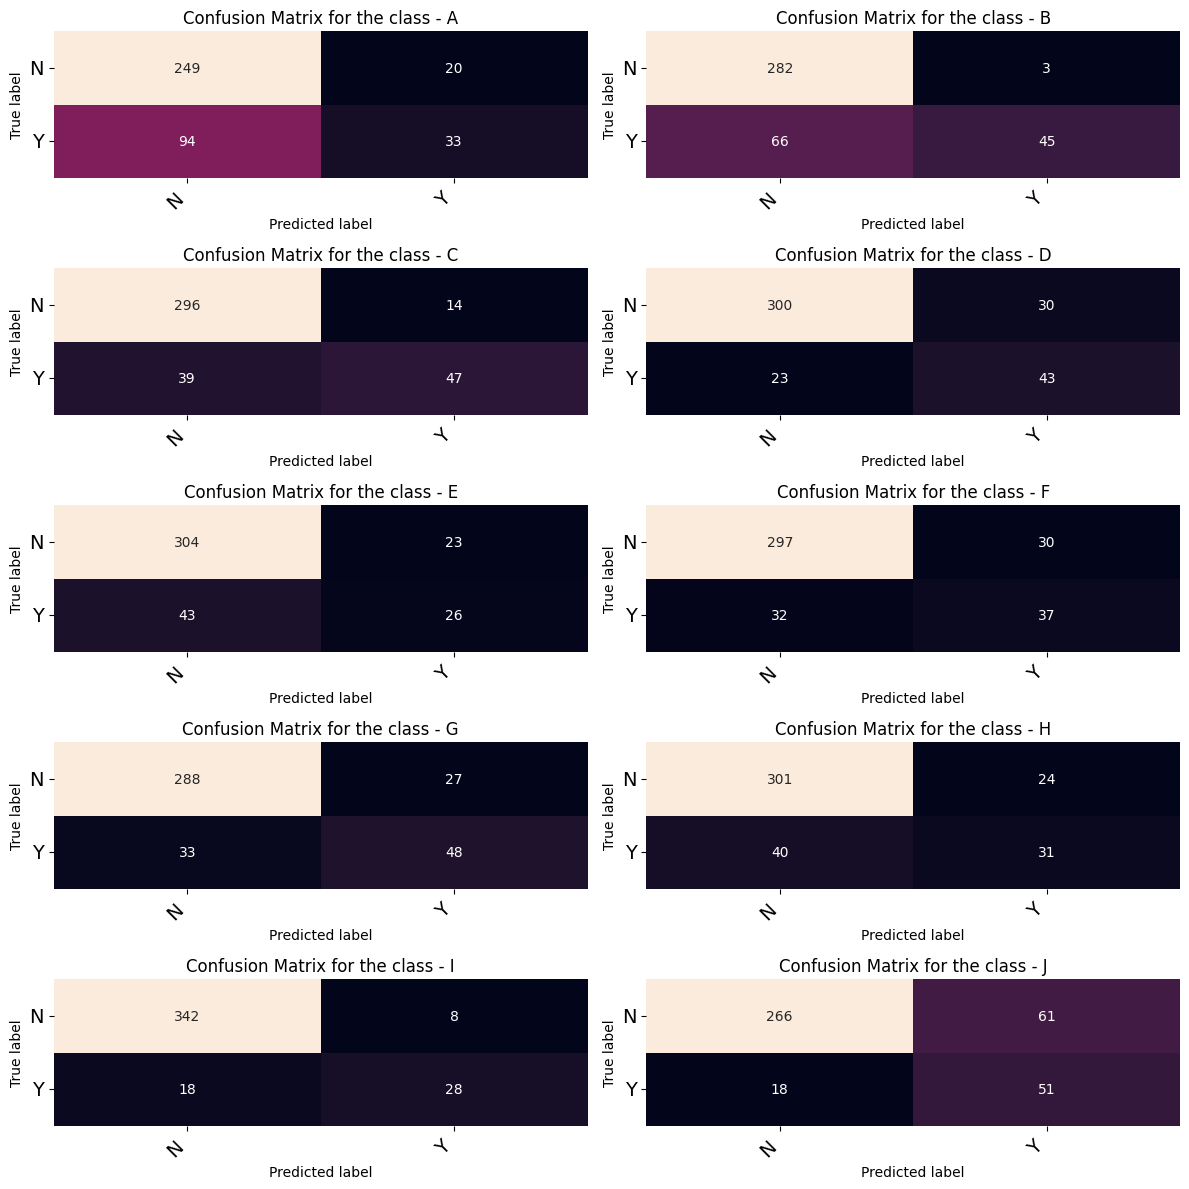

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [1]:
print('classes: ', labels)
tn = cm[:, 0, 0]
tp = cm[:, 1, 1]
fn = cm[:, 1, 0]
fp = cm[:, 0, 1]
recall = tp / (tp + fn)
print('recall: ',recall)
specificity = tn / (tn + fp)
print('specificity: ',specificity)
FPR = fp / (fp + tn)
print('FPR: ',FPR)
FNR = fn / (fn + tp)
print('FNR: ',FNR)
precision = tp/ (tp + fp)
print('precision: ',precision)

NameError: name 'labels' is not defined

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred,target_names=labels)
print(report)

              precision    recall  f1-score   support

           A       0.62      0.26      0.37       127
           B       0.94      0.41      0.57       111
           C       0.77      0.55      0.64        86
           D       0.59      0.65      0.62        66
           E       0.53      0.38      0.44        69
           F       0.55      0.54      0.54        69
           G       0.64      0.59      0.62        81
           H       0.56      0.44      0.49        71
           I       0.78      0.61      0.68        46
           J       0.46      0.74      0.56        69

   micro avg       0.62      0.49      0.55       795
   macro avg       0.64      0.52      0.55       795
weighted avg       0.66      0.49      0.54       795
 samples avg       0.44      0.37      0.38       795



/Users/sindhuja/Applications/anaconda3/envs/facemask/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sindhuja/Applications/anaconda3/envs/facemask/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
report

'              precision    recall  f1-score   support\n\n           A       0.62      0.26      0.37       127\n           B       0.94      0.41      0.57       111\n           C       0.77      0.55      0.64        86\n           D       0.59      0.65      0.62        66\n           E       0.53      0.38      0.44        69\n           F       0.55      0.54      0.54        69\n           G       0.64      0.59      0.62        81\n           H       0.56      0.44      0.49        71\n           I       0.78      0.61      0.68        46\n           J       0.46      0.74      0.56        69\n\n   micro avg       0.62      0.49      0.55       795\n   macro avg       0.64      0.52      0.55       795\nweighted avg       0.66      0.49      0.54       795\n samples avg       0.44      0.37      0.38       795\n'

# Confusion matrix for Face Recognition using IOU

In [22]:
# predicted labels including unknown faces
lbl_pred = []
fname_pred = []
for k,faces in parse_json.items():
    t = []
    fname_pred.append(k)
    for f in faces:
#         print(f['lbl'])
#         if f['pred_indv_id'] > 0:
        t.append(f['pred_indv_id'])
    lbl_pred.append(t)

In [23]:
# ground truth
bbox_truth = []
# fname_truth = []
lbl_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'H':8, 'I':9, 'J':10}
lbl_truth = []
for file in fname_pred:
    b = []
    l = []
    if file in d:
        for f in d[file]:
            l.append(lbl_map[f['lbl']])
            b.append(f['bbox'])
    bbox_truth.append(b)    
    lbl_truth.append(l)

In [24]:
# predicted
bbox_pred = []
for k,faces in parse_json.items():
    b = []
    for f in faces:
#         print(f['lbl'])
#         if f['pred_indv_id'] > 0:
        b.append(f['bbox'])
    bbox_pred.append(b)

In [25]:
# top, right, bottom, left
# x1 0 = left 3
# y1 1= top 0
# w1 2= right - left 1 - 3
# h1 3= top - bottom 0-2

In [26]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[3], pred_box[3]), max(gt_box[0], pred_box[0])]
#     inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[3]+(gt_box[1]-gt_box[3]), pred_box[3]+(pred_box[1]-pred_box[3])), 
                              min(gt_box[0]+(gt_box[0]-gt_box[2]), pred_box[0]+(pred_box[0]-pred_box[2]))]
#     inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = (gt_box[1]-gt_box[3]) * (gt_box[0]-gt_box[2]) + (pred_box[1]-pred_box[3]) * (pred_box[0]-pred_box[2]) - intersection
#     union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou

In [27]:
bbox_truth[0]

[[360.5240174672489,
  409.40868140868145,
  507.2489082969432,
  297.02866502866505],
 [256.5589519650655, 1001.5004095004095, 319.4410480349345, 948.6650286650287],
 [239.7903930131004, 798.5454545454546, 305.1877729257642, 750.7420147420148]]

In [77]:
# tp, fp, tn, fn
labels = ['unknown','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','undetected']
results = np.zeros((12, 12))
for i,fname in enumerate(fname_pred):
    res = np.zeros((12, 12))
    for j,plist in  enumerate(bbox_pred[i]):
        for k,tlist in enumerate(bbox_truth[i]):
            iou = intersection_over_union(plist,tlist)
            t_lbl = lbl_truth[i][k]
            if iou > 0.50:
                p_lbl = lbl_pred[i][j]
                res[t_lbl][p_lbl] += 1
#                 res[p_lbl][t_lbl] += 1
            else:
                res[t_lbl][11] += 1
#                 res[11][t_lbl] += 1
#     print(res)
    sub_extra =len(bbox_pred[i])-1
#     print(sub_extra)
    for l in range(8):
        res[l][11] = res[l][11]-sub_extra if res[l][11] > 0 else 0
#         res[11][l] = res[11][l]-sub_extra if res[11][l] > 0 else 0
#     print(res)
    results = results + res
results

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.],
       [ 26.,  17.,   0.,   6.,   0.,   4.,   1.,   6.,   3.,   0.,  25.,
         39.],
       [ 28.,   0.,  40.,   0.,  11.,   2.,   3.,   3.,   0.,   0.,   5.,
         19.],
       [ 18.,   0.,   2.,  41.,   0.,   1.,   1.,   0.,   1.,   0.,   8.,
         14.],
       [ 12.,   1.,   0.,   3.,  34.,   1.,   3.,   0.,   7.,   0.,   2.,
         17.],
       [ 14.,   0.,   1.,   2.,   0.,  18.,   2.,   3.,   4.,   1.,   4.,
         21.],
       [ 16.,   1.,   0.,   1.,   1.,   0.,  31.,   0.,   1.,   0.,   3.,
         15.],
       [ 15.,   0.,   2.,   1.,   0.,   1.,   0.,  40.,   2.,   1.,   1.,
         18.],
       [ 12.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,  29.,   1.,  12.,
        447.],
       [ 13.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,  27.,   0.,
        335.],
       [ 12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,  49.,
        457.],
       [  0.,   0.,  

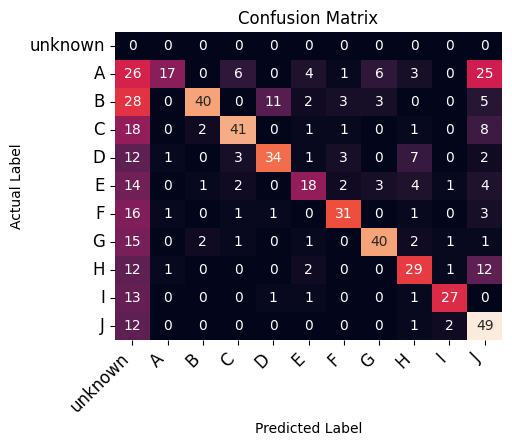

In [60]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
labels = ['unknown','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
df_cm = pd.DataFrame(
        results[:11,:11], index=labels, columns=labels,
    )

heatmap = sns.heatmap(df_cm, annot=True, fmt=".3g",cbar=False)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

## Chandler

In [ ]:
# precision recall f1-score support
# Precision (macro avg) = (Precision of A + Precision of B + Precision of C) / 3
# micro avg (precision) = sum(Tp) / (sum(TP) + sum(FP))
# 

In [100]:
labels = ['unknown','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
cf = results[:11,:11]
cf_res = []
precision = []
recall = []
f1_score = []
support = []
for i,count_lst in enumerate(cf):
    if i == 0:
        continue
    tp = count_lst[i]
    fn = sum(count_lst) - tp
    fp = sum(cf[:,i]) - tp
    tn = np.sum(cf)-np.sum(cf[:,i])-np.sum(cf[i,:])+tp
#     print('i = ', i)
#     print(tp, fn, fp, tn)
    cf_res.append([tp, fn, fp, tn])
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2*p*r / (p+r)
    s = sum(cf[:,i])
    precision.append(p)
    recall.append(r)
    f1_score.append(f1)
    support.append(s)
# print(cf_res)


In [81]:
cf_res

[[17.0, 71.0, 3.0, 554.0],
 [40.0, 52.0, 5.0, 548.0],
 [41.0, 31.0, 13.0, 560.0],
 [34.0, 29.0, 13.0, 569.0],
 [18.0, 31.0, 12.0, 584.0],
 [31.0, 23.0, 10.0, 581.0],
 [40.0, 23.0, 12.0, 570.0],
 [29.0, 28.0, 20.0, 568.0],
 [27.0, 16.0, 5.0, 597.0],
 [49.0, 15.0, 60.0, 521.0]]

In [101]:
wt_avg_pres = np.dot(precision, support)/np.sum(support)
wt_avg_recall = np.dot(recall, support)/np.sum(support)
wt_avg_f1score = np.dot(f1_score, support)/np.sum(support)


In [118]:
sum(support)

479.0

In [120]:
# Micro F1
total_tp = sum(np.array(cf_res)[:,0])
total_fn = sum(np.array(cf_res)[:,1])
total_fp = sum(np.array(cf_res)[:,2])
total_tn = sum(np.array(cf_res)[:,3])
total_precision = total_tp / (total_tp + total_fp) # micro avg precision
total_recall = total_tp / (total_tp + total_fn) # micro avg recall
micro_f1 = 2*total_precision*total_recall / (total_precision+total_recall)
total_support = sum(support)

In [103]:
macro_f1 = sum(f1_score)/10
macro_avg_precision = sum(precision)/10
macro_avg_recall = sum(recall)/10


In [104]:
acc = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
acc

0.9268217054263566

## classification report

In [111]:
# '{:.2f}'.format(number)
'              precision    recall  f1-score   support\n\n           A       0.62      0.26      0.37       127\n           B       0.94      0.41      0.57       111\n           C       0.77      0.55      0.64        86\n           D       0.59      0.65      0.62        66\n           E       0.53      0.38      0.44        69\n           F       0.55      0.54      0.54        69\n           G       0.64      0.59      0.62        81\n           H       0.56      0.44      0.49        71\n           I       0.78      0.61      0.68        46\n           J       0.46      0.74      0.56        69\n\n   micro avg       0.62      0.49      0.55       795\n   macro avg       0.64      0.52      0.55       795\nweighted avg       0.66      0.49      0.54       795\n samples avg       0.44      0.37      0.38       795\n'


'              precision    recall  f1-score   support\n\n           A       0.62      0.26      0.37       127\n           B       0.94      0.41      0.57       111\n           C       0.77      0.55      0.64        86\n           D       0.59      0.65      0.62        66\n           E       0.53      0.38      0.44        69\n           F       0.55      0.54      0.54        69\n           G       0.64      0.59      0.62        81\n           H       0.56      0.44      0.49        71\n           I       0.78      0.61      0.68        46\n           J       0.46      0.74      0.56        69\n\n   micro avg       0.62      0.49      0.55       795\n   macro avg       0.64      0.52      0.55       795\nweighted avg       0.66      0.49      0.54       795\n samples avg       0.44      0.37      0.38       795\n'

In [129]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
text = "\nCLASSIFICATION REPORT\n\n              precision\trecall\tf1-score\tsupport\n\n"
for i in range(10):
    text = text + '           {}\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.1f}\n'.format(labels[i],precision[i],recall[i],f1_score[i],support[i])
text = text + '\n\n    accuracy\t\t\t{:.2f}\t\t{:.0f}'.format(acc,total_support)
text = text + '\n   micro avg\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.0f}'.format(total_precision,total_recall,micro_f1,total_support)
text = text + '\n   macro avg\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.0f}'.format(macro_avg_precision,macro_avg_recall,macro_f1,total_support)
text = text + '\nweighted avg\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.0f}'.format(wt_avg_pres,wt_avg_recall,wt_avg_f1score,total_support)

print(text+'\n')


CLASSIFICATION REPORT

              precision	recall	f1-score	support

           A	0.85	0.19	0.31		20.0
           B	0.89	0.43	0.58		45.0
           C	0.76	0.57	0.65		54.0
           D	0.72	0.54	0.62		47.0
           E	0.60	0.37	0.46		30.0
           F	0.76	0.57	0.65		41.0
           G	0.77	0.63	0.70		52.0
           H	0.59	0.51	0.55		49.0
           I	0.84	0.63	0.72		32.0
           J	0.45	0.77	0.57		109.0


    accuracy			0.93		479
   micro avg	0.68	0.51	0.58		479
   macro avg	0.72	0.52	0.58		479
weighted avg	0.68	0.58	0.59		479

